SDG Indicator comparison
- I. Read rasters
- II. Zonal stats 
- III. Plot

In [1]:
#package
import rasterio
import geopandas as gp
import numpy as np
from rasterstats import zonal_stats
from rasterio.plot import show

In [2]:
# data declaration
trd = 'data/Trend earth/TE_Jigawa.tif' # trend earth 
spl = 'data/sepal/Jigawa_indicator_15_3_1_merge.tif' # sepal 
jig = 'data/Jigawa.shp' # from FAO GAUL

In [3]:
# Function for raster file descrition
def RasIn(path):
    """
    This function describe the raster depending on the raster path given:
    path: Raster path
    returns: raster description including the Nodata value and restoration label representative value
    """
    with rasterio.open(path) as src:
        array = src.read(1)
    num = np.unique(array)
    show(array)
    print('Image shape: ', src.shape)
    print('File path: ',src.name)
    print('Unique values in raster : ', num)
    print('Nodata:',num[0])
    print('Degradation: %2d, Stable: %2d, Improvement: %2d' % (num[1],num[2],num[3]))

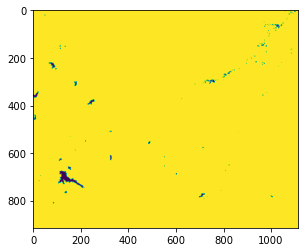

Image shape:  (915, 1112)
File path:  data/Trend earth/TE_Jigawa.tif
Unique values in raster :  [-32768     -1      0      1]
Nodata: -32768
Degradation: -1, Stable:  0, Improvement:  1


In [4]:
RasIn(trd)

In [5]:
def zon_stats(shp, sepal, trend):
    """
    This function estimate the pixel based count of the sdg indicator 15.3.1 from both sepal and trend
    input--
    shp: the path the shapefile, read as geodataframe
    sepal: sepal raster path
    trend: trend raster path
    ----
    returns:
    The area in Km^2 per category of the SDG 15.3.1 Indicator (Degraded, Stable and Improve)
    """
    import rasterio
    
    #read sepal
    src1 = rasterio.open(sepal) #read sepal
    spl_arr = src1.read(1)
    
    #read trend earth
    src2 = rasterio.open(trend)
    tr_arr = src2.read(1)
    
    shf = gp.read_file(shp) # from FAO GAUL
    
    from rasterstats import zonal_stats
    #zonal stats for sdg indicator module from seapl
    c_sepal ={1:'Degraded', 2:'Stable',3:'Improved'} #categorical rename
    affine_spl = src1.transform #affine selector
    s_stats = zonal_stats(shf, spl_arr, affine=affine_spl, categorical=True, category_map=c_sepal, nodata=0.0) #zonal stats
    
    #zonal stats for trend earth
    c_trend ={-1:'Degraded', 0:'Stable',1:'Improved'}
    affine_trend = src2.transform
    t_stats = zonal_stats(shf, tr_arr, affine=affine_trend, categorical=True, category_map=c_trend, nodata=-32768)

    #
    sepal_stats = s_stats[0]
    sepal_stats.update((x,y*0.0001) for x,y in sepal_stats.items()) #0.0001 spatial resolution in Km^2
    
    trend_stats = t_stats[0]
    trend_stats.update((x,y*0.0625) for x,y in trend_stats.items()) #0.0625
    print('Area in Km^2 per category for SDG 15.3.1 Indicator module: ', sepal_stats)
    print('Area in Km^2 per category for Trend earth SDG 15.3.1 Indicator:  ', trend_stats)
    return sepal_stats, trend_stats

In [18]:
sepal, trend = zon_stats(jig, spl, trd) #boundary shapefile, sepal raster and trend earth raster

Area in Km^2 per category for SDG 15.3.1 Indicator module:  {'Degraded': 602.9453, 'Stable': 1972.8008, 'Improved': 1.4466}
Area in Km^2 per category for Trend earth SDG 15.3.1 Indicator:   {'Degraded': 5931.0, 'Stable': 12662.375, 'Improved': 5217.75}


In [20]:
def chart(dict_in):
    from matplotlib import pyplot as plt
    dic = sorted(dict_in.items(), key=lambda kv: kv[1], reverse=True)
    i,j =zip(*dic)

    fig, ax = plt.subplots(figsize=(16, 9))
    ax.barh(i, j)
    ax.set_title('Pixel count per category in Area (SquareKM)')
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')
    

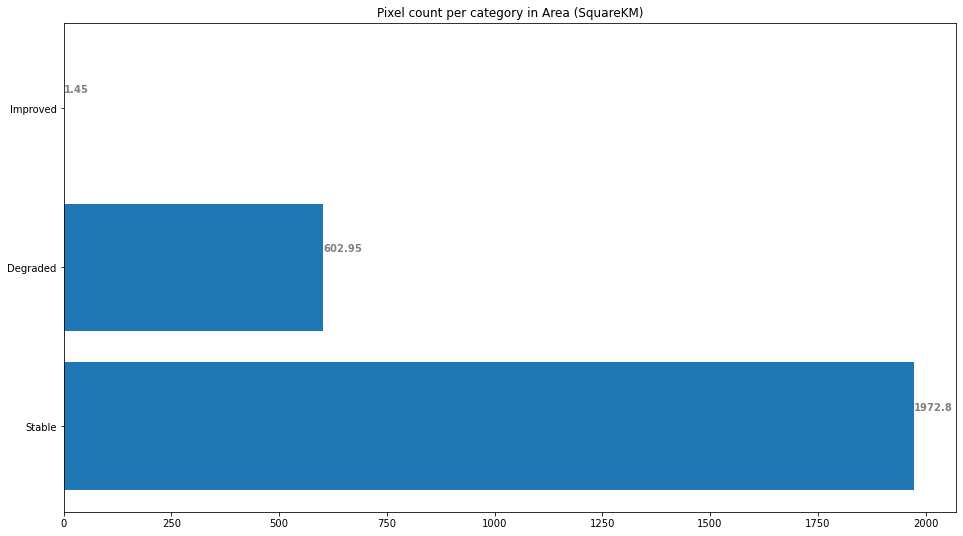

In [21]:
chart(sepal)

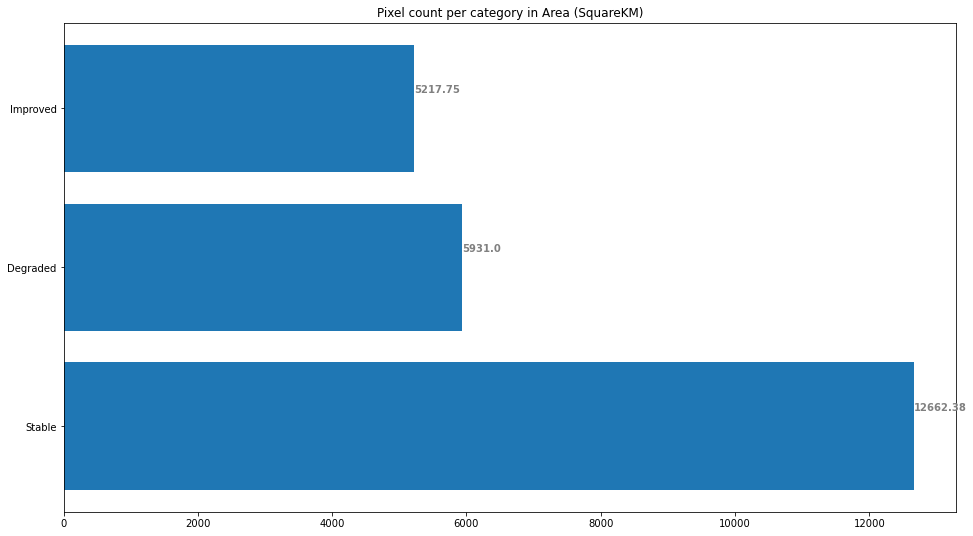

In [22]:
chart(trend)